# Importing

In [6]:
# importing modules
import os
import numpy as np
import mne

Reading the file & loading in the data

In [7]:
raw = mne.io.read_raw_brainvision("FaceWord_Group3.vhdr", eog=('EOG1', 'EOG2'), misc='auto', scale=1.0, preload=False, verbose=None)

raw.info['bads'] = ['TP10', 'T7']


Extracting parameters from FaceWord_Group3.vhdr...
Setting channel info structure...


# View raw data

In [8]:
raw.load_data()

Reading 0 ... 352979  =      0.000 ...   352.979 secs...


<RawBrainVision | FaceWord_Group3.eeg, 32 x 352980 (353.0 s), ~86.2 MB, data loaded>

Looking at the ouput from the load.data() function, try to figure out:

- How many EEG channels?
- Do you see any EEG channels marked as bad during recording?
- What is the sampling frequency?
- How many minutes of data were recorded?

# Getting output specific for our technique of measuring (10-20)

In [9]:
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, verbose=False)

<RawBrainVision | FaceWord_Group3.eeg, 32 x 352980 (353.0 s), ~86.2 MB, data loaded>

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


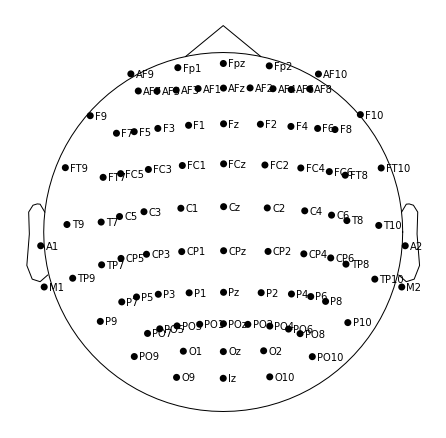

In [10]:
mne.viz.plot_montage(montage, scale_factor=20, show_names=True, kind='topomap', show=True, sphere=None, verbose=None);

Plotting the electrode placements

If I wanna see the channels which was active in my experiment

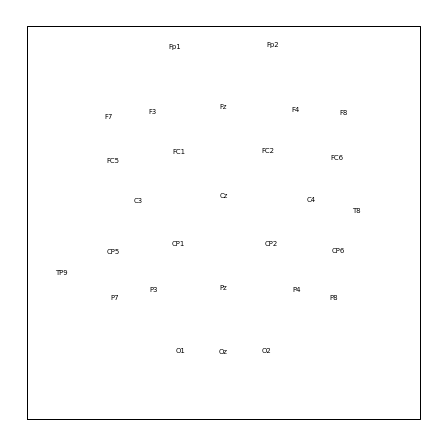

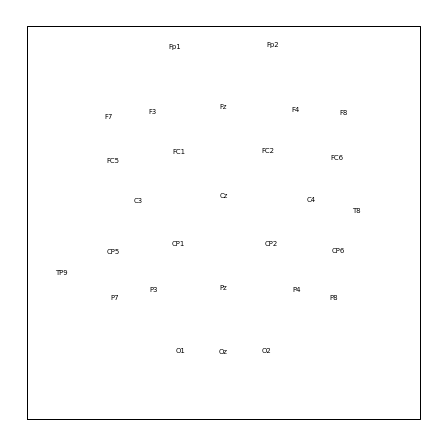

In [11]:
hest = mne.channels.make_eeg_layout(raw.info, radius=0.5, width=None, height=None, csd=False)

hest.plot()

# View channels

Using matplotlib as 2D backend.


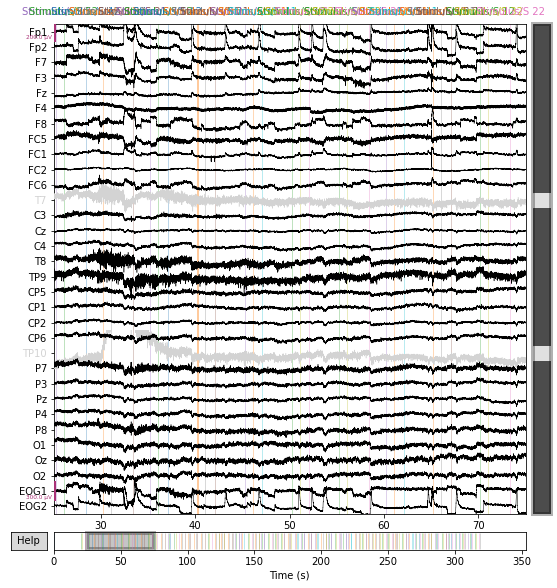

In [12]:
mne.viz.plot_raw(raw, n_channels = 32, scalings = dict(eeg = 1e-4), start = 25, duration = 50);
# I zoom in the data with "start" and "duration"

# Filtering

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



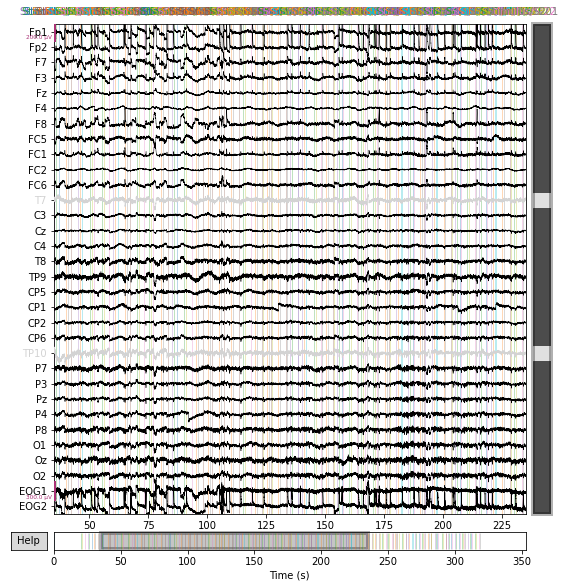

In [13]:
# high-pass filtering the data at 0.1 Hz and subsequently low-pass filtering at 40 Hz
raw = raw.filter(0.1, None)
raw = raw.filter(None, 40)

# plotting the filtered data for inspection
#raw.plot(n_channels = 30, start = 0, duration = 20);

mne.viz.plot_raw(raw, n_channels = 32, scalings = dict(eeg = 100e-6), start = 35, duration = 200);

# Artefact removal

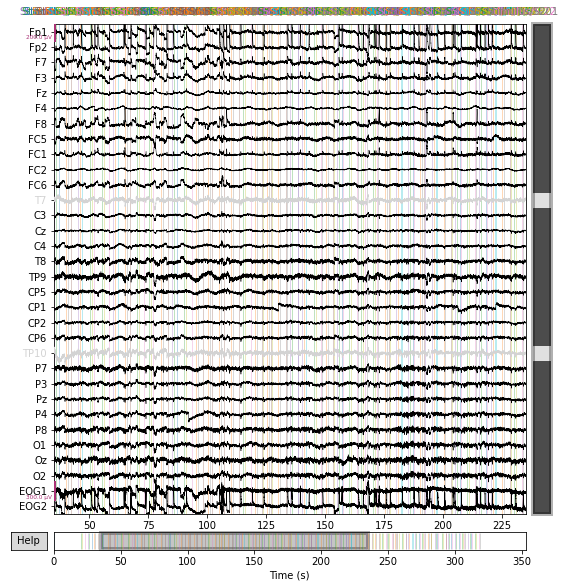

In [14]:
# rejecting everything over or under a threshold of 150 microvolts
# anything above or belove this threshold is likely not brain activity but artefacts
reject = dict(eeg=150e-6)

# plotting the data for inspection
#raw.plot(n_channels = 30, );

mne.viz.plot_raw(raw, n_channels = 32, scalings = dict(eeg = 100e-6), start = 35, duration = 200);

In [15]:
triggers = mne.events_from_annotations(raw)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 41', 'Stimulus/S 42', 'Stimulus/S 51', 'Stimulus/S 52', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S112', 'Stimulus/S201', 'Stimulus/S202', 'Stimulus/S212']


In [16]:
np.unique(triggers[0][:,2])

array([   11,    12,    13,    21,    22,    31,    32,    41,    42,
          51,    52,   101,   102,   112,   201,   202,   212, 99999])

In [17]:
list(triggers[1].values())

[99999,
 11,
 12,
 13,
 21,
 22,
 31,
 32,
 41,
 42,
 51,
 52,
 101,
 102,
 112,
 201,
 202,
 212]

In [18]:
# we can make a dictionary of what the event IDs represent
# by using '/' we can actually later index one dimension *across* the other, i.e. if we just write 'left' we get all events presented to the left side, both auditory and visual

event_id = {'Word/wPos': 11, # positive word
 'Wait/wPos': 31, # waiting time after positive word
 'Image/wPos': 21, # positive image (always following pos word)
 'Word/wNeg': 12, # negative word
 'Wait/wNeg': 32, # waiting time after negative word
 'Image/wNeg': 22, # negative image (always following neg word)
 'Word/wNeu': 13, # neutral word
 'Wait/wNeu/iPos': 51, # wait time after neu w (before pos i)
 'Image/wNeu/iPos': 41, # positive image (after neu word)
 'Wait/wNeu/iNeg': 52, # wait time after neu w (before neg i)
 'Image/wNeu/iNeg': 42, # negative image (after neu word)
 'Incorrect/wPos': 101, # correct response ('b') to pos w + image
 'Incorrect/wNeg': 102, # correct response ('y') to neg w + image
 #'Incorrect/wNeu/iPos': 111, # cor resp ('b') to neu w + pos image
 'Incorrect/wNeu/iNeg': 112, # cor resp ('y') to neu w + neg image
 'Correct/wPos': 202, # incor resp ('y') to pos w + image
 'Correct/wNeg': 201, # incor resp ('b') to neg w + image
 'Correct/wNeu/iPos': 212 # incor resp ('y') to neu w + pos i
 #'Correct/Neu/iNeg': 211 # incor resp ('b') to neu w + neg i
 }

/tmp/ipykernel_174/395223243.py:2: RuntimeWarning: event 99999 missing from event_id will be ignored
  mne.viz.plot_events(triggers[0], event_id=event_id);
/tmp/ipykernel_174/395223243.py:2: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(triggers[0], event_id=event_id);


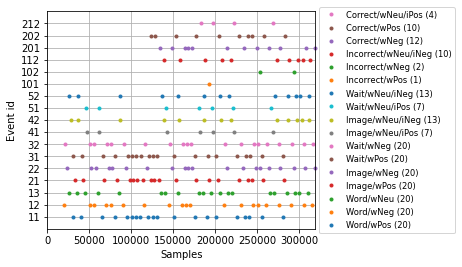

In [19]:
# plotting the events
mne.viz.plot_events(triggers[0], event_id=event_id);

# Epoch

The time window we establish span from 0.2 seconds before stimulus onset to 0.5 seconds after stimulus onset. The 200 milliseconds before the onset of the stimulus enables us to examine a baseline of activity without stimulus presentation. The 500 milliseconds after the stimulus onset denote the time in which we expect the effect to occur, since most EEG components arise before the 500 milliseconds mark.

In [20]:
# establishing time window
tmin, tmax = -0.2, 0.5

# choosing only EEG channels for epoching
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False)

In [21]:
# creating the epochs using the variables created in the cell above, and timelocking to the events
# baseline time interval spans from beginning of the data (-0.2 s) to 0 s (stimulus onset)
# we use the reject variable we created earlier in order to remove artefacts
epochs = mne.Epochs(raw, triggers[0], event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=reject, preload=True)

Not setting metadata
Not setting metadata
219 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 219 events and 701 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'F8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'F8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['F8', 'FC6']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch

# Downsampling
Downsampling to 250 Hz


In [22]:
# downsampling to 250 Hz
epochs_resampled = epochs.resample(250)

# ERPs
Now we can group the epochs by modality (auditory/visual) and take a look at the differences between them!

Not setting metadata
Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


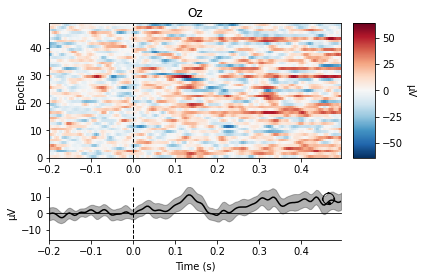

Not setting metadata
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


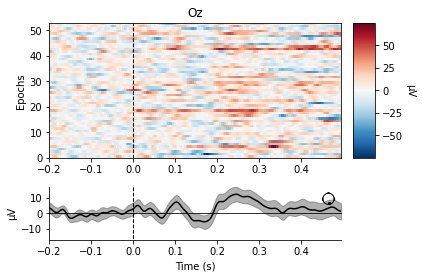

In [23]:
# now the '/' used in the event IDs comes in handy! To get all epochs with auditory stimuli, we can index 'auditory' across the left/right dimension (and 'visual', of course)
# that way we don't have to specify 'auditory_left' and 'auditory_right' etc.
word_epochs = epochs_resampled['Word']
image_epochs = epochs_resampled['Image']

# plotting one channel as an example for each modality
word_epochs.plot_image(picks=['Oz']);
image_epochs.plot_image(picks=['Oz']);



These plots show each epoch as one row of the image map for the chosen channel, with color representing signal magnitude. The average evoked response and the sensor location are shown below the image. This gives us an idea of whether there is consistency in the signal.

In your view, which is the most consistent signal of the two? Why do you think that is?

(hint 1: where is the EEG 021 channel located on the scalp?)

(hint 2: maybe try using plot_sensors and flagging show_names=True)

Which channel would you choose if you were to reverse the pattern of the signal consistencies? Go ahead and try it out...

In [24]:
words_evoked = word_epochs.average() # [all words]
images_evoked = image_epochs.average() # [all images]

wordpos_epochs = epochs_resampled['Word/wPos']
wordneg_epochs = epochs_resampled['Word/wNeg']
wordneu_epochs = epochs_resampled['Word/wNeu']

wordspos_evoked = wordpos_epochs.average() 
wordsneg_evoked = wordneg_epochs.average() 
wordsneu_evoked = wordneu_epochs.average() 

imagepos_epochs = epochs_resampled['Image/wPos']
imageneg_epochs = epochs_resampled['Image/wNeg']
imageneu_epochs = epochs_resampled['Image/wNeu/iNeg', 'Image/wNeu/iPos']

imagepos_evoked = imagepos_epochs.average() 
imageneg_evoked = imageneg_epochs.average() 
imageneu_evoked = imageneu_epochs.average() 

imageneuneg_epochs = epochs_resampled['Image/wNeu/iNeg']
imageneupos_epochs = epochs_resampled['Image/wNeu/iPos']

imageneuneg_evoked = imageneuneg_epochs.average() 
imageneupos_evoked = imageneupos_epochs.average() 

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


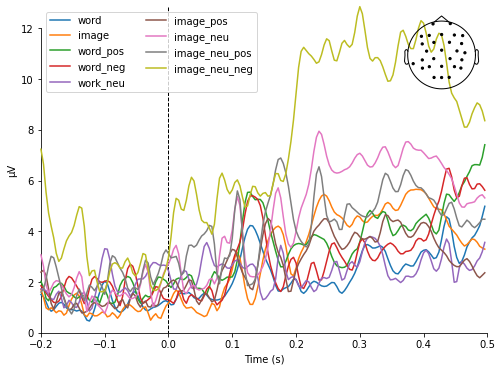

[<Figure size 576x432 with 2 Axes>]

In [25]:
# plotting the two evokeds together
mne.viz.plot_compare_evokeds(dict(word=words_evoked, 
                                  image=images_evoked, 
                                  word_pos=wordspos_evoked, 
                                  word_neg=wordsneg_evoked, 
                                  work_neu=wordsneu_evoked, 
                                  image_pos=imagepos_evoked, 
                                  image_neu=imageneu_evoked, 
                                  image_neu_pos=imageneuneg_evoked, 
                                  image_neu_neg = imageneupos_evoked),
                             legend='upper left', show_sensors='upper right')

# Response times
Eliciting response times using the triggers from the button-presses: Copy the code from the rt_code_snippet.py in the scripts-folder to your notebook and try to run it (it’s a bit dense, I know). Can you get a sensible output? If not, we’ll play around with this at a later stage.

In [26]:
triggers_list = list(triggers)

In [27]:
# RT code snippet
events_tmp = triggers_list.copy() # making a copy of the events structure so we don't fiddle with the original structure
rt = np.zeros([np.shape(events_tmp)[0],2]) # creating an rt-structure with zeros, same length as events and 2 columns
for idx, line in enumerate(events_tmp): # iterating over each line in the events structure
    if any(line[2] == [101,102,111,112]): # picking out only the correct-response lines
        rt[idx] = (line[2],line[0]-events_tmp[idx-1,0]) # subtracting the timestamps of the preceding image from the from that of the response
pure_rt = rt[np.nonzero(rt[:,0]),][0] # creating a structure only with response times (i.e. no "blank" lines for all the other triggers from word, image, etc.)
mean_rt = [(x, np.mean(pure_rt[pure_rt[:,0]==x,1]), 
                    np.std(pure_rt[pure_rt[:,0]==x,1])) 
                   for x in np.unique(pure_rt[:,0])] # calculating the mean and standard deviation of the rt for each unique trigger value in pure_rt (using list comprehension)
[print("{}: {:5.2f} (±{:5.2f}) ms\n".format(list(event_id.keys())[list(event_id.values()).index(i)],
                                            j,k)) for i,j,k in mean_rt] # printing those values (using list comprehension)

image_rt = np.concatenate(([events_tmp[np.nonzero(rt[:,0])[0]-1,2]], [rt[np.nonzero(rt[:,0]),1][0]]), axis=0).T # concatenating image-triggers with the relevant rts
mean_image_rt = [(x, np.mean(image_rt[image_rt[:,0]==x,1]), 
                  np.std(image_rt[image_rt[:,0]==x,1])) 
                 for x in np.unique(image_rt[:,0])] # calculating the mean and standard deviation of the rt for each unique trigger value in image_rt (should be identical to the response-categories
[print("{}: {:5.2f} (±{:5.2f}) ms\n".format(list(event_id.keys())[list(event_id.values()).index(i)],
                                            j,k)) for i,j,k in mean_image_rt] # printing those values

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/tmp/ipykernel_174/4019683765.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if any(line[2] == [101,102,111,112]): # picking out only the correct-response lines


TypeError: 'bool' object is not iterable